In [31]:
print('Start importing required libraries...')
import os, sys, time
sys.path.append('../')
from tqdm.auto import tqdm
import allel
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
torch.autograd.set_detect_anomaly(True)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
from collections import Counter
import gzip
import tagore
from scipy.interpolate import interp1d

from lainet.models.network_constructor import get_network
from lainet.utils.eval import compute_accuracy, AccuracyLogger, complete_sk_eval, print_sk_eval
from lainet.utils.reader import load_founders_from_vcf_and_map, load_results_file
from lainet.utils.output_writer import get_meta_data, write_msp_tsv
from lainet.training import train_main, eval_predictions
from lainet.inference import inference_main 

print('Done importing')

#importing module (only for jupytercluster)
exec(open("/shared/software/modules/4.6.1/init/python.py").read(), globals())
module("load", "bcftools")

module("load","conda")
os.system("source activate TER")
print("conda env has been loaded")
print("bcftools has been loaded")

Start importing required libraries...
Done importing
conda env has been loaded
bcftools has been loaded


In [32]:
config_path = 'configs/test-small.yaml'
data_folder= '../data/input/real/'

founders_vcf_file_path = data_folder+ '5pop_1425sample.vcf.gz'
founders_map_file_path = data_folder+ '5pop_1425sample.smap'

query_vcf_file_path = data_folder+ '5pop_285query.vcf.gz'
genetic_map=data_folder +'allchrs_b37.gmap'

output_folder_prefix = '../data/output_lainet/1425samples_285query/'
if (os.path.isdir(output_folder_prefix)==False):
    os.mkdir(output_folder_prefix)
    print('Creating directory')

chm=1
# Load vcf and map files and config
config = yaml.load(open(config_path), Loader=yaml.FullLoader)

print(config)

{'MODEL': {'NETWORK': 'lainet', 'WINDOW_SIZE': 500}, 'TRAINING': {'DEVICE': 'cuda', 'OPTIM': 'Adam', 'ALPHA': 0.5, 'LEARNING_RATE': 0.01, 'WEIGHT_DECAY': 0.0, 'BATCH_SIZE': 128, 'BALANCED_TYPE': 'Batch', 'ONLINE_SIMULATION_MODE': 'pre-defined', 'ONLINE_SIMULATION_REALISTIC': True, 'GENERATION_NUM_LIST': [2, 4, 16, 32, 64], 'RANDOM_TRAINVAL_SPLIT': False, 'ITER_BREAK': 10, 'NUM_EPOCHS': 20000, 'SAVE_MODEL': True}}


In [13]:
## Training
train_main(config, founders_vcf_file_path, founders_map_file_path, output_folder_prefix,chm,genetic_map)

Loading vcf and .map files...
Done loading vcf and .map files...
A total of 1424 diploid individuals where found in the vcf and .map
A total of 5 ancestries where found: ['AFR' 'AMR' 'EAS' 'EUR' 'SAS']
A total of 2564 sequences are used for training and 284 for validation...
A total of 5 unique categories in train and 5 in val
Reading genetic map from... ../data/input/real/allchrs_b37.gmap
Information of models saved in ../data/output_lainet/lnetwork/1425samples_285query/_info.npy...
Creating Network...
Starting training...
Saving network in... ../data/output_lainet/lnetwork/1425samples_285query/_0__network_model.pth
Using genetic map for realistic simulation
Validation set of shape torch.Size([534, 65535]) has been simulated...
400625
[     1] loss: 0.839
 accuracy is: 20.69 - Best is: 20.69 - Difference is: 0.00 - Time since best: 0
[     3] loss: 1.659
[     5] loss: 1.519
[     7] loss: 1.373
[     9] loss: 1.369
[    11] loss: 1.316
 accuracy is: 39.67 - Best is: 39.67 - Differenc

/shared/ifbstor1/projects/machinelearning_popgen/ter-bioinfo/LAI-NET/lainet/training.py:381: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels = torch.tensor(val_labels_).to('cpu')


Hard prediction evaluation

              precision    recall  f1-score   support

         AFR       0.85      0.85      0.85     14022
         AMR       0.55      0.35      0.43     14023
         EAS       0.92      0.89      0.91     13889
         EUR       0.51      0.75      0.61     14009
         SAS       0.80      0.73      0.76     14011

    accuracy                           0.71     69954
   macro avg       0.73      0.72      0.71     69954
weighted avg       0.73      0.71      0.71     69954




Soft prediction evaluation

        AP
---  -----
AFR  0.882
AMR  0.542
EAS  0.969
EUR  0.599
SAS  0.855



Confusion Matrix

       AFR    AMR    EAS    EUR    SAS
---  -----  -----  -----  -----  -----
AFR  11855    682    142   1127    216
AMR   1473   4954    251   6472    873
EAS    185    301  12426    396    581
EUR    219   2156    211  10542    881
SAS    208    882    435   2266  10220



Confusion Matrix (Normalized)

       AFR    AMR    EAS    EUR    SAS
---  ---

In [42]:
## Inference
net, predicted, probs, val_snps = inference_main(config, query_vcf_file_path, output_folder_prefix, output_folder_prefix)

Starting inference...
Loading best performing networks...
Loading Meta-data...
Loading query vcf in...../data/input/real/5pop_285query.vcf.gz
- Number of SNPs from model: 65535
- Number of SNPs from file: 65535
- Number of intersecting SNPs: 65535
- Percentage of model SNPs covered by query file: 100.0%
Running network...
torch.Size([285, 131, 2])
Writing .msp file...
Done writing


In [43]:
print('Plotting results!')
output_file = output_folder_prefix+"msp.tsv"

msp_df = pd.read_csv(output_file, sep="\t")
msp_df

Plotting results!


#Subpopulation order/codes: AFR=0  \
#chm spos     epos     sgpos egpos n snps NA19834.0 NA19834.1 NA20278.0 NA20278.1 NA19030.0 NA19030.1 HG03470.0 HG03470.1 HG02878.0 HG02878.1 NA18853.0 NA18853.1 NA20127.0 NA20127.1 NA19473.0 NA19473.1 NA19908.0 NA19908.1 NA18523.0 NA18523.1 HG03372.0 HG03372.1 HG02582.0 HG02582.1 HG02623.0 HG02623.1 HG02805.0 HG02805.1 HG03246.0 HG03246.1 HG03303.0 HG03303.1 HG02817.0 HG02817.1 NA19454.0 NA19454.1 HG03472.0 HG03472.1 HG03126.0 HG03126.1 NA19152.0 NA19152.1 HG03449.0 HG03449.1 HG02722.0 HG02722.1 HG03575.0 HG03575.1 HG01890.0 HG01890.1 NA20282.0 NA20282.1 HG03298.0 HG03298.1 HG02944.0 HG02944.1 HG03055.0 HG03055.1 HG01882.0 HG01882.1 HG03455.0 HG03455.1 HG03464.0 HG03464.1 NA18867.0 NA18867.1 NA20357.0 NA20357.1 HG02620.0 HG02620.1 NA20296.0 NA20296.1 HG03160.0 HG03160.1 HG01985.0 HG01985.1 NA18877.0 NA18877.1 NA19036.0 NA19036.1 NA19914.0 NA19914.1 HG02810.0 HG02810.1 NA19206.0 NA19206.1 HG03130.0 HG03130.1 NA18865.0 NA18865.1 HG02861.0 HG02861.1 NA19118.0 NA19118.1 NA18876.0 NA18876.1 NA19027.0 NA19027.1 HG03060.0 HG03060.1 NA19374.0 NA19374.1 HG02887.0 HG02887.1 HG02813.0 HG02813.1 HG02610.0 HG02610.1 HG03391.0 HG03391.1 HG02771.0 HG02771.1 HG03517.0 HG03517.1 NA18971.0 NA18971.1 HG01867.0 HG01867.1 NA19068.0 NA19068.1 HG01796.0 HG01796.1 HG01873.0 HG01873.1 NA18608.0 NA18608.1 NA18640.0 NA18640.1 NA19078.0 NA19078.1 NA18543.0 NA18543.1 HG00708.0 HG00708.1 NA18597.0 NA18597.1 HG01847.0 HG01847.1 HG00557.0 HG00557.1 HG00478.0 HG00478.1 HG00707.0 HG00707.1 NA18956.0 NA18956.1 NA20832.0 NA20832.1 HG00513.0 HG00513.1 HG02130.0 HG02130.1 NA18539.0 NA18539.1 HG00475.0 HG00475.1 HG02351.0 HG02351.1 NA21141.0 NA21141.1 NA20586.0 NA20586.1 HG03824.0 HG03824.1 NA20765.0 NA20765.1 NA19077.0 NA19077.1 HG00155.0 HG00155.1 HG02141.0 HG02141.1 HG01842.0 HG01842.1 NA18579.0 NA18579.1 HG01673.0 HG01673.1 NA18632.0 NA18632.1 NA18745.0 NA18745.1 NA11894.0 NA11894.1 HG00625.0 HG00625.1 HG03593.0 HG03593.1 HG00319.0 HG00319.1 NA11892.0 NA11892.1 HG02736.0 HG02736.1 HG03976.0 HG03976.1 HG00276.0 HG00276.1 HG00662.0 HG00662.1 HG04047.0 HG04047.1 NA19075.0 NA19075.1 HG04059.0 HG04059.1 NA12006.0 NA12006.1 HG03234.0 HG03234.1 NA18537.0 NA18537.1 NA18942.0 NA18942.1 NA20529.0 NA20529.1 HG03905.0 HG03905.1 HG04002.0 HG04002.1 NA12347.0 NA12347.1 HG03902.0 HG03902.1 HG01794.0 HG01794.1 HG01624.0 HG01624.1 HG02236.0 HG02236.1 NA12546.0 NA12546.1 HG00654.0 HG00654.1 HG02375.0 HG02375.1 HG02383.0 HG02383.1 HG03838.0 HG03838.1 HG04029.0 HG04029.1 HG00120.0 HG00120.1 NA20521.0 NA20521.1 HG03652.0 HG03652.1 NA12283.0 NA12283.1 NA19074.0 NA19074.1 HG00174.0 HG00174.1 HG02152.0 HG02152.1 NA19003.0 NA19003.1 HG03625.0 HG03625.1 NA20760.0 NA20760.1 NA18961.0 NA18961.1 NA21113.0 NA21113.1 HG00629.0 HG00629.1 HG00590.0 HG00590.1 HG02491.0 HG02491.1 HG03971.0 HG03971.1 HG03875.0 HG03875.1 NA11930.0 NA11930.1 HG03898.0 HG03898.1 NA21133.0 NA21133.1 HG02792.0 HG02792.1 HG01709.0 HG01709.1 NA18545.0 NA18545.1 NA20769.0 NA20769.1 NA20901.0 NA20901.1 NA18952.0 NA18952.1 HG00182.0 HG00182.1 HG02023.0 HG02023.1 HG00437.0 HG00437.1 NA18615.0 NA18615.1 HG00531.0 HG00531.1 NA18538.0 NA18538.1 HG01802.0 HG01802.1 HG03812.0 HG03812.1 HG02697.0 HG02697.1 HG00361.0 HG00361.1 HG03867.0 HG03867.1 HG02398.0 HG02398.1 NA20517.0 NA20517.1 NA20810.0 NA20810.1 HG01791.0 HG01791.1 NA18629.0 NA18629.1 HG00290.0 HG00290.1 NA12874.0 NA12874.1 HG00607.0 HG00607.1 NA07051.0 NA07051.1 HG00185.0 HG00185.1 NA19056.0 NA19056.1 HG02661.0 HG02661.1 HG01866.0 HG01866.1 NA20813.0 NA20813.1 HG00110.0 HG00110.1 HG03646.0 HG03646.1 HG00542.0 HG00542.1 NA19081.0 NA19081.1 HG02783.0 HG02783.1 HG01521.0 HG01521.1 NA07000.0 NA07000.1 NA20511.0 NA20511.1 NA20854.0 NA20854.1 NA20867.0 NA20867.1 NA12873.0 NA12873.1 HG03977.0 HG03977.1 NA21088.0 NA21088.1 HG00150.0 HG00150.1 NA21127.0 NA21127.1 NA11829.0 NA11829.1 HG03868.0 HG03868.1 NA20859.0 NA20859.1 NA12763.0 NA12763.1 HG03730.0 HG03730.1 HG04118.0 HG04118.1 NA20764.0 NA20764.1 HG01747.0 HG01747.1 HG00253.0 HG00253.1 H

## Measuring performance

In [50]:
from scipy import stats
from sklearn.metrics import confusion_matrix

from lainet.postprocess import get_samples_from_msp_df
from lainet.visualization import plot_cm, plot_chm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
msp_df = pd.read_csv(output_file, sep="\t",skiprows=[0])
# reading the sample-ids
query_samples = get_samples_from_msp_df(msp_df)

# reading predictions for each of the intervals
pred_labels = (np.array(msp_df)[:,6:].T).astype(int)
# reducing it to only 1 of maternal/paternal prediction
single_ind_idx = np.arange(0,len(query_samples)*2,2)
pred_labels_single_ind = pred_labels[single_ind_idx,:]


# predicting single ancestry by taking mode of local predictions for each individual
y_pred = stats.mode(pred_labels_single_ind,axis=1)[0].squeeze() 

# get model population order from first line of file and convert from numeric predictions
with open(output_file, "r") as f:
    pop = np.array([p.split("=")[0] for p in f.readline().split()[2:]])
pred_pop = [pop[pop_ind] for pop_ind in y_pred]

# put it together in dataframe
pred_df = pd.DataFrame({"Sample": query_samples, "Prediction": pred_pop})


## Adding the true labels

In [52]:
# adding the true labels
all_sample_map_file=data_folder + 'all_sample.smap'
all_sample_map_df = pd.read_csv(all_sample_map_file, sep="\t",skiprows=[0])
all_sample_map_df.columns = ['Sample', 'Superpopulation code']
true_labels_df = all_sample_map_df[["Sample", "Superpopulation code"]]
true_labels_df.columns = ["Sample", "Population"]
pred_df = pred_df.merge(true_labels_df)
print(pred_df)

      Sample Prediction Population
0    NA19834        AFR        AFR
1    NA20278        EUR        AFR
2    NA19030        AFR        AFR
3    HG03470        AFR        AFR
4    HG02878        AFR        AFR
..       ...        ...        ...
279  HG02278        AMR        AMR
280  HG01060        EUR        AMR
281  HG01082        AMR        AMR
282  HG01272        AMR        AMR
283  HG01933        AMR        AMR

[284 rows x 3 columns]


In [53]:
# Getting the prediction accuracy
acc = np.mean(pred_df.Population == pred_df.Prediction)

print("Accuracy for single ancestry: ", acc*100, "%", sep="")

#writting accuracy in a file
res=pd.read_csv("../data/res.tsv",delimiter='\t',header=0)

Accuracy for single ancestry: 95.07042253521126%


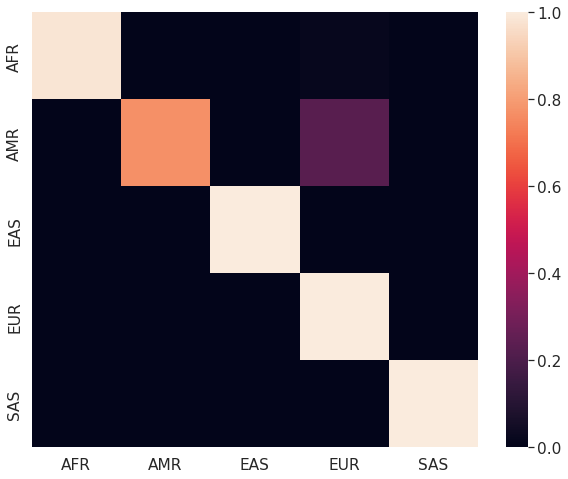

In [54]:
# creating and visualizing the confusion matrix
labs = np.unique(pred_df[['Population', 'Prediction']])
cm = confusion_matrix(pred_df.Population, pred_df.Prediction, labels=labs)
cm_plot = plot_cm(cm, normalize=True, labels=labs)
cm_plot.figure.savefig(f'{output_folder_prefix}confusion_matrix.png')

## Plotting the prediction

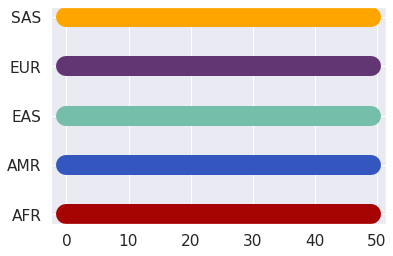

tagore --i ../data/output_lainet/lnetwork/1425samples_285query/tagore.tsv -p ../data/output_lainet/lnetwork/1425samples_285query/HG01060_chm_img --build hg37 -f


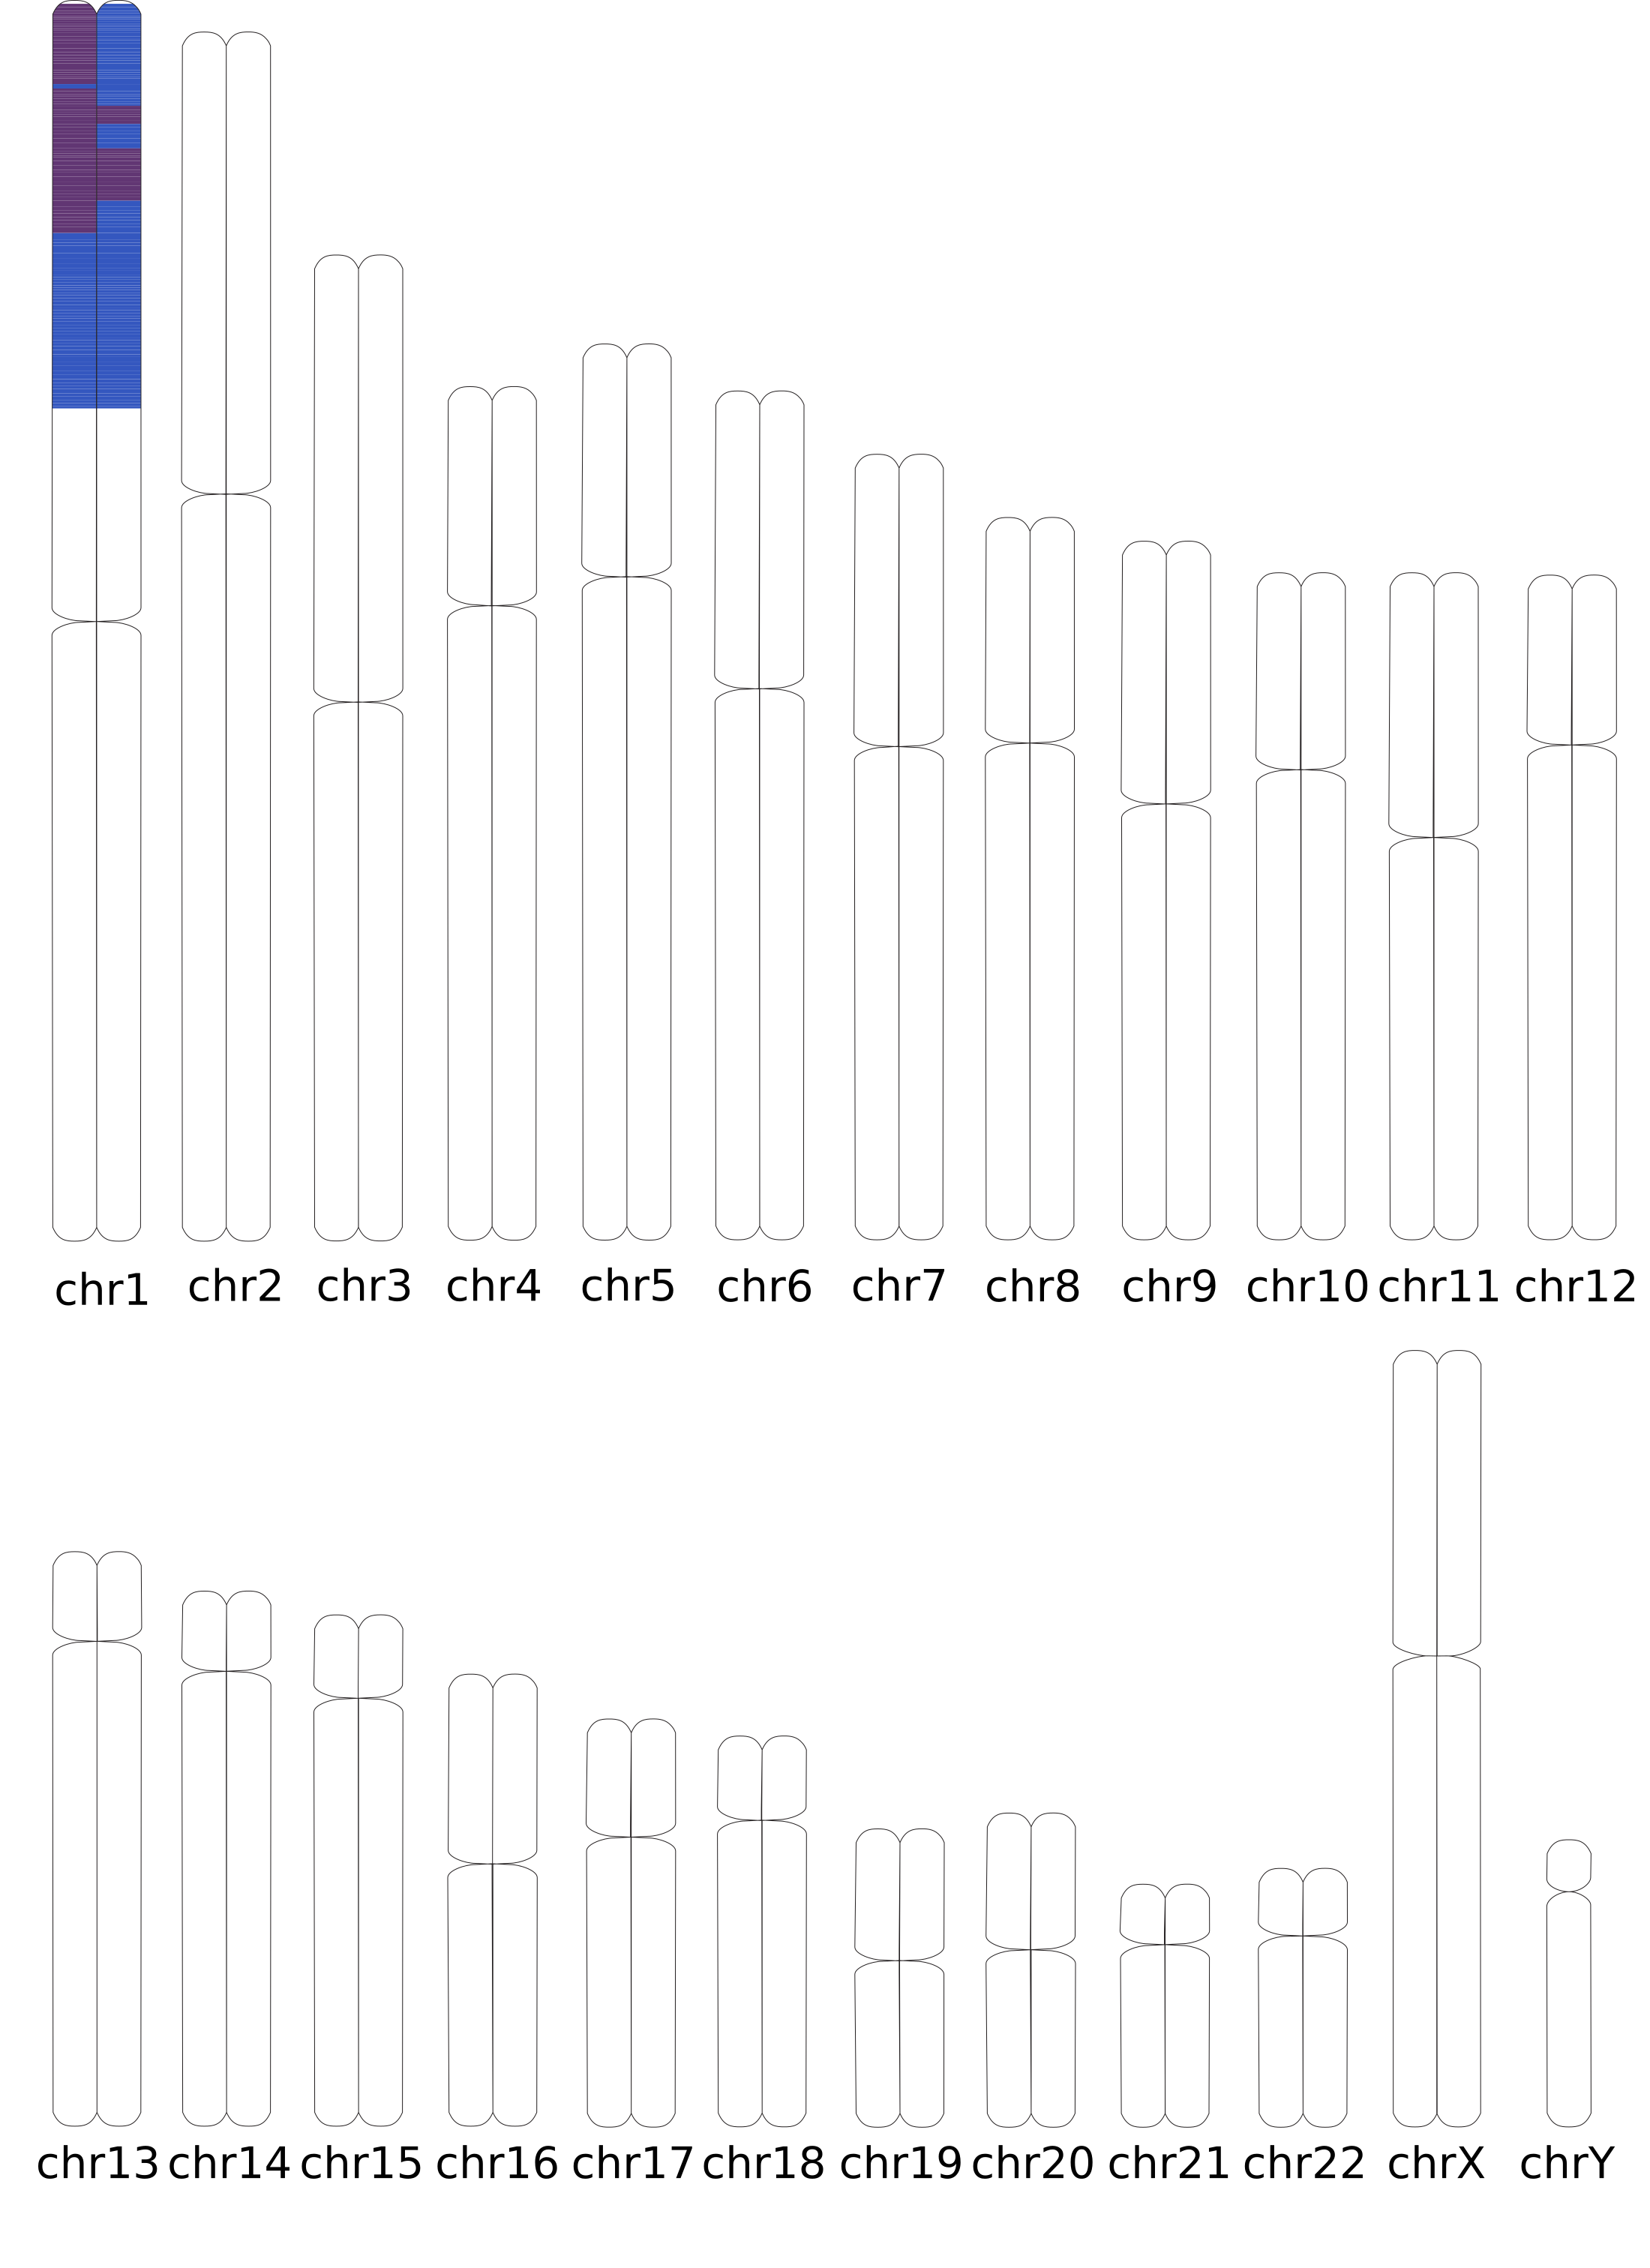

In [56]:
from IPython.display import Image

sample_id = "HG01060" # looking at just one random sample
img_name = f"{output_folder_prefix}{sample_id}_chm_img"
plot_chm(sample_id, msp_df,output_folder_prefix,output_file, img_name=img_name)
Image(filename=img_name+".png",retina=True)